In [3]:
# Imports and Setup
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Use Agg backend for matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # Ensures non-GUI backend if only plt is imported

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# Kaggle inline plotting
%matplotlib inline

# Set the seaborn style
sns.set(style='whitegrid')

# Display a note in the logs
print('Libraries imported and setup complete.')

Libraries imported and setup complete.


In [6]:
# Data Loading
file_path = 'loan_approval_dataset.csv'
df = pd.read_csv(file_path, encoding='ascii', delimiter=',')

# A quick look at the data
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [7]:
# Quick summary of the dataset
print(df.info())
print(df.describe())

# Since some column names have extra spaces, let's strip them
df.columns = df.columns.str.strip()

# Check for missing values
print('Missing values in each column:')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB
None
          

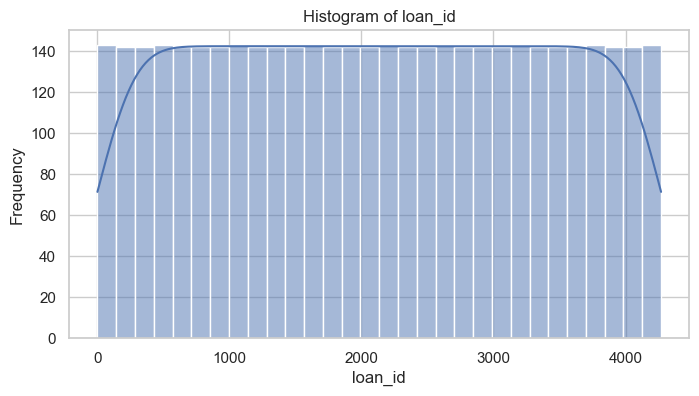

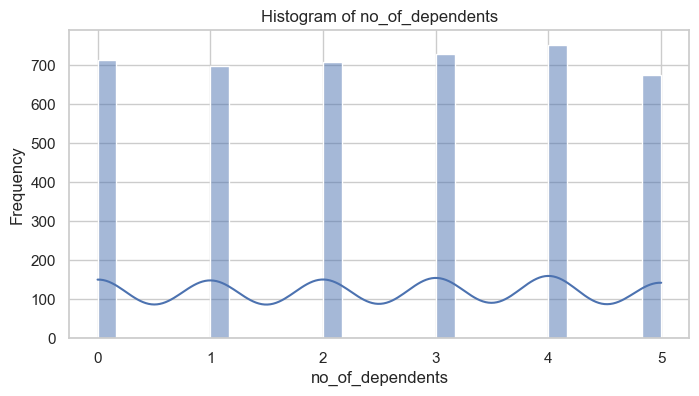

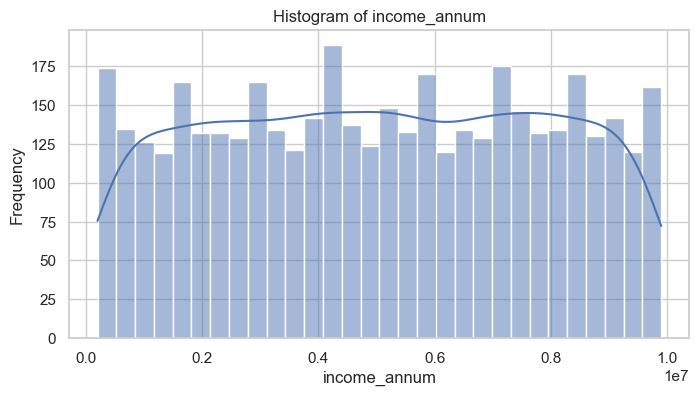

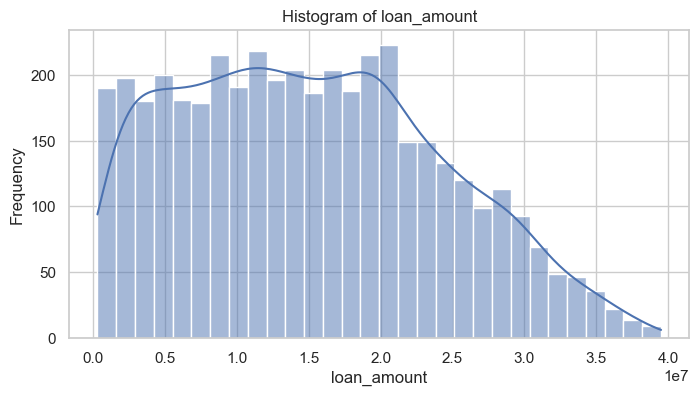

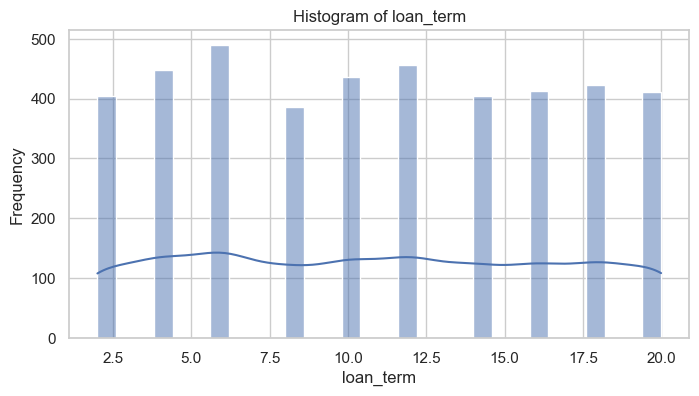

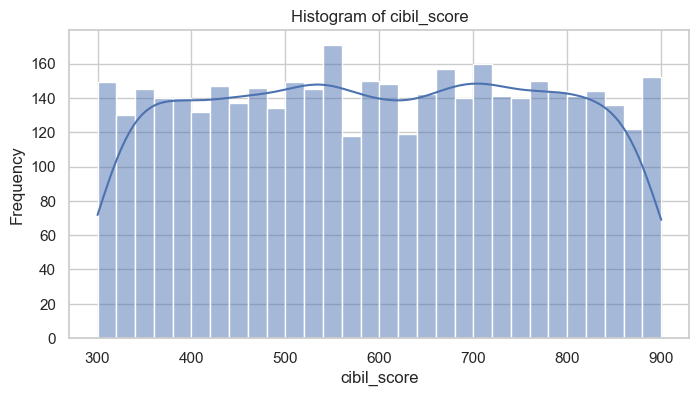

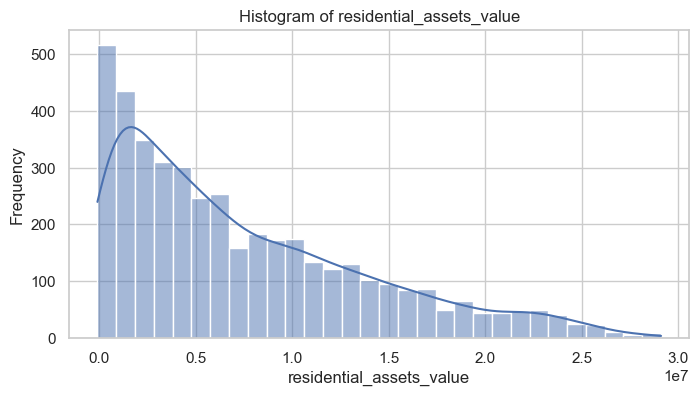

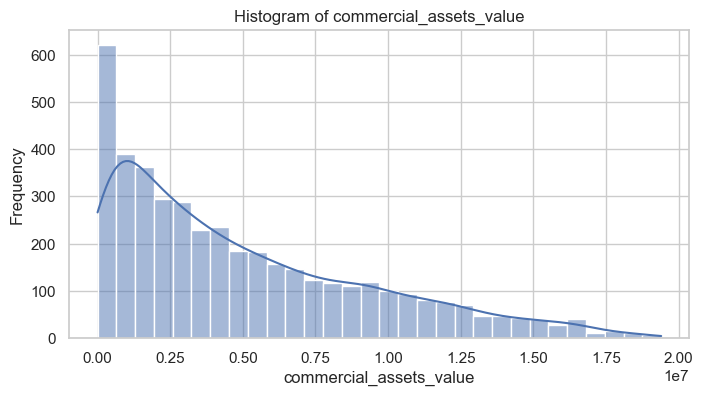

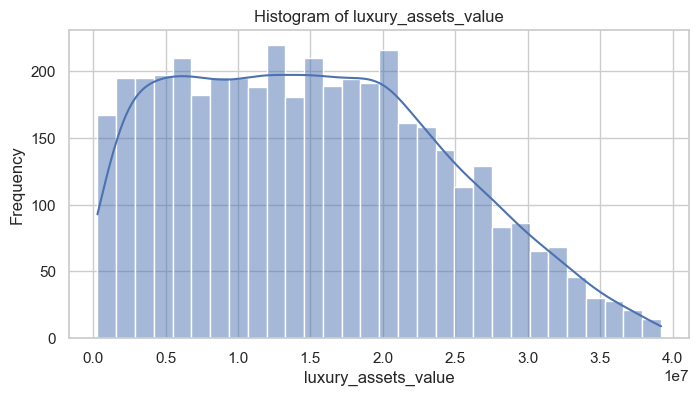

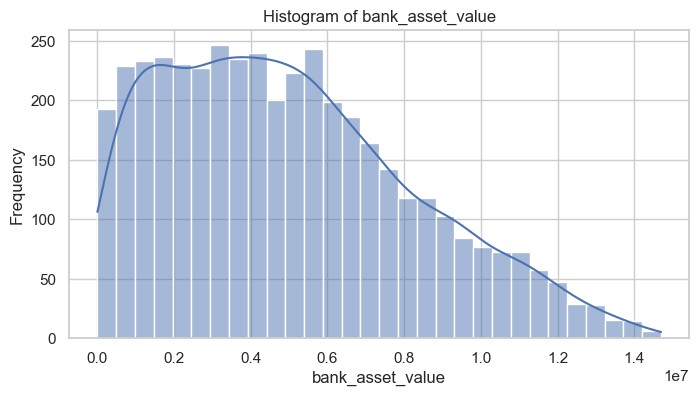

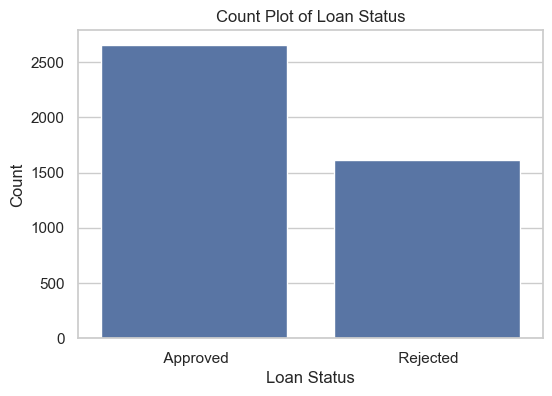

In [8]:
# Visualizations for EDA

# Histogram for numeric distribution
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Count plot (Pie Chart style alternative) for target variable 'loan_status'
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=df)
plt.title('Count Plot of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

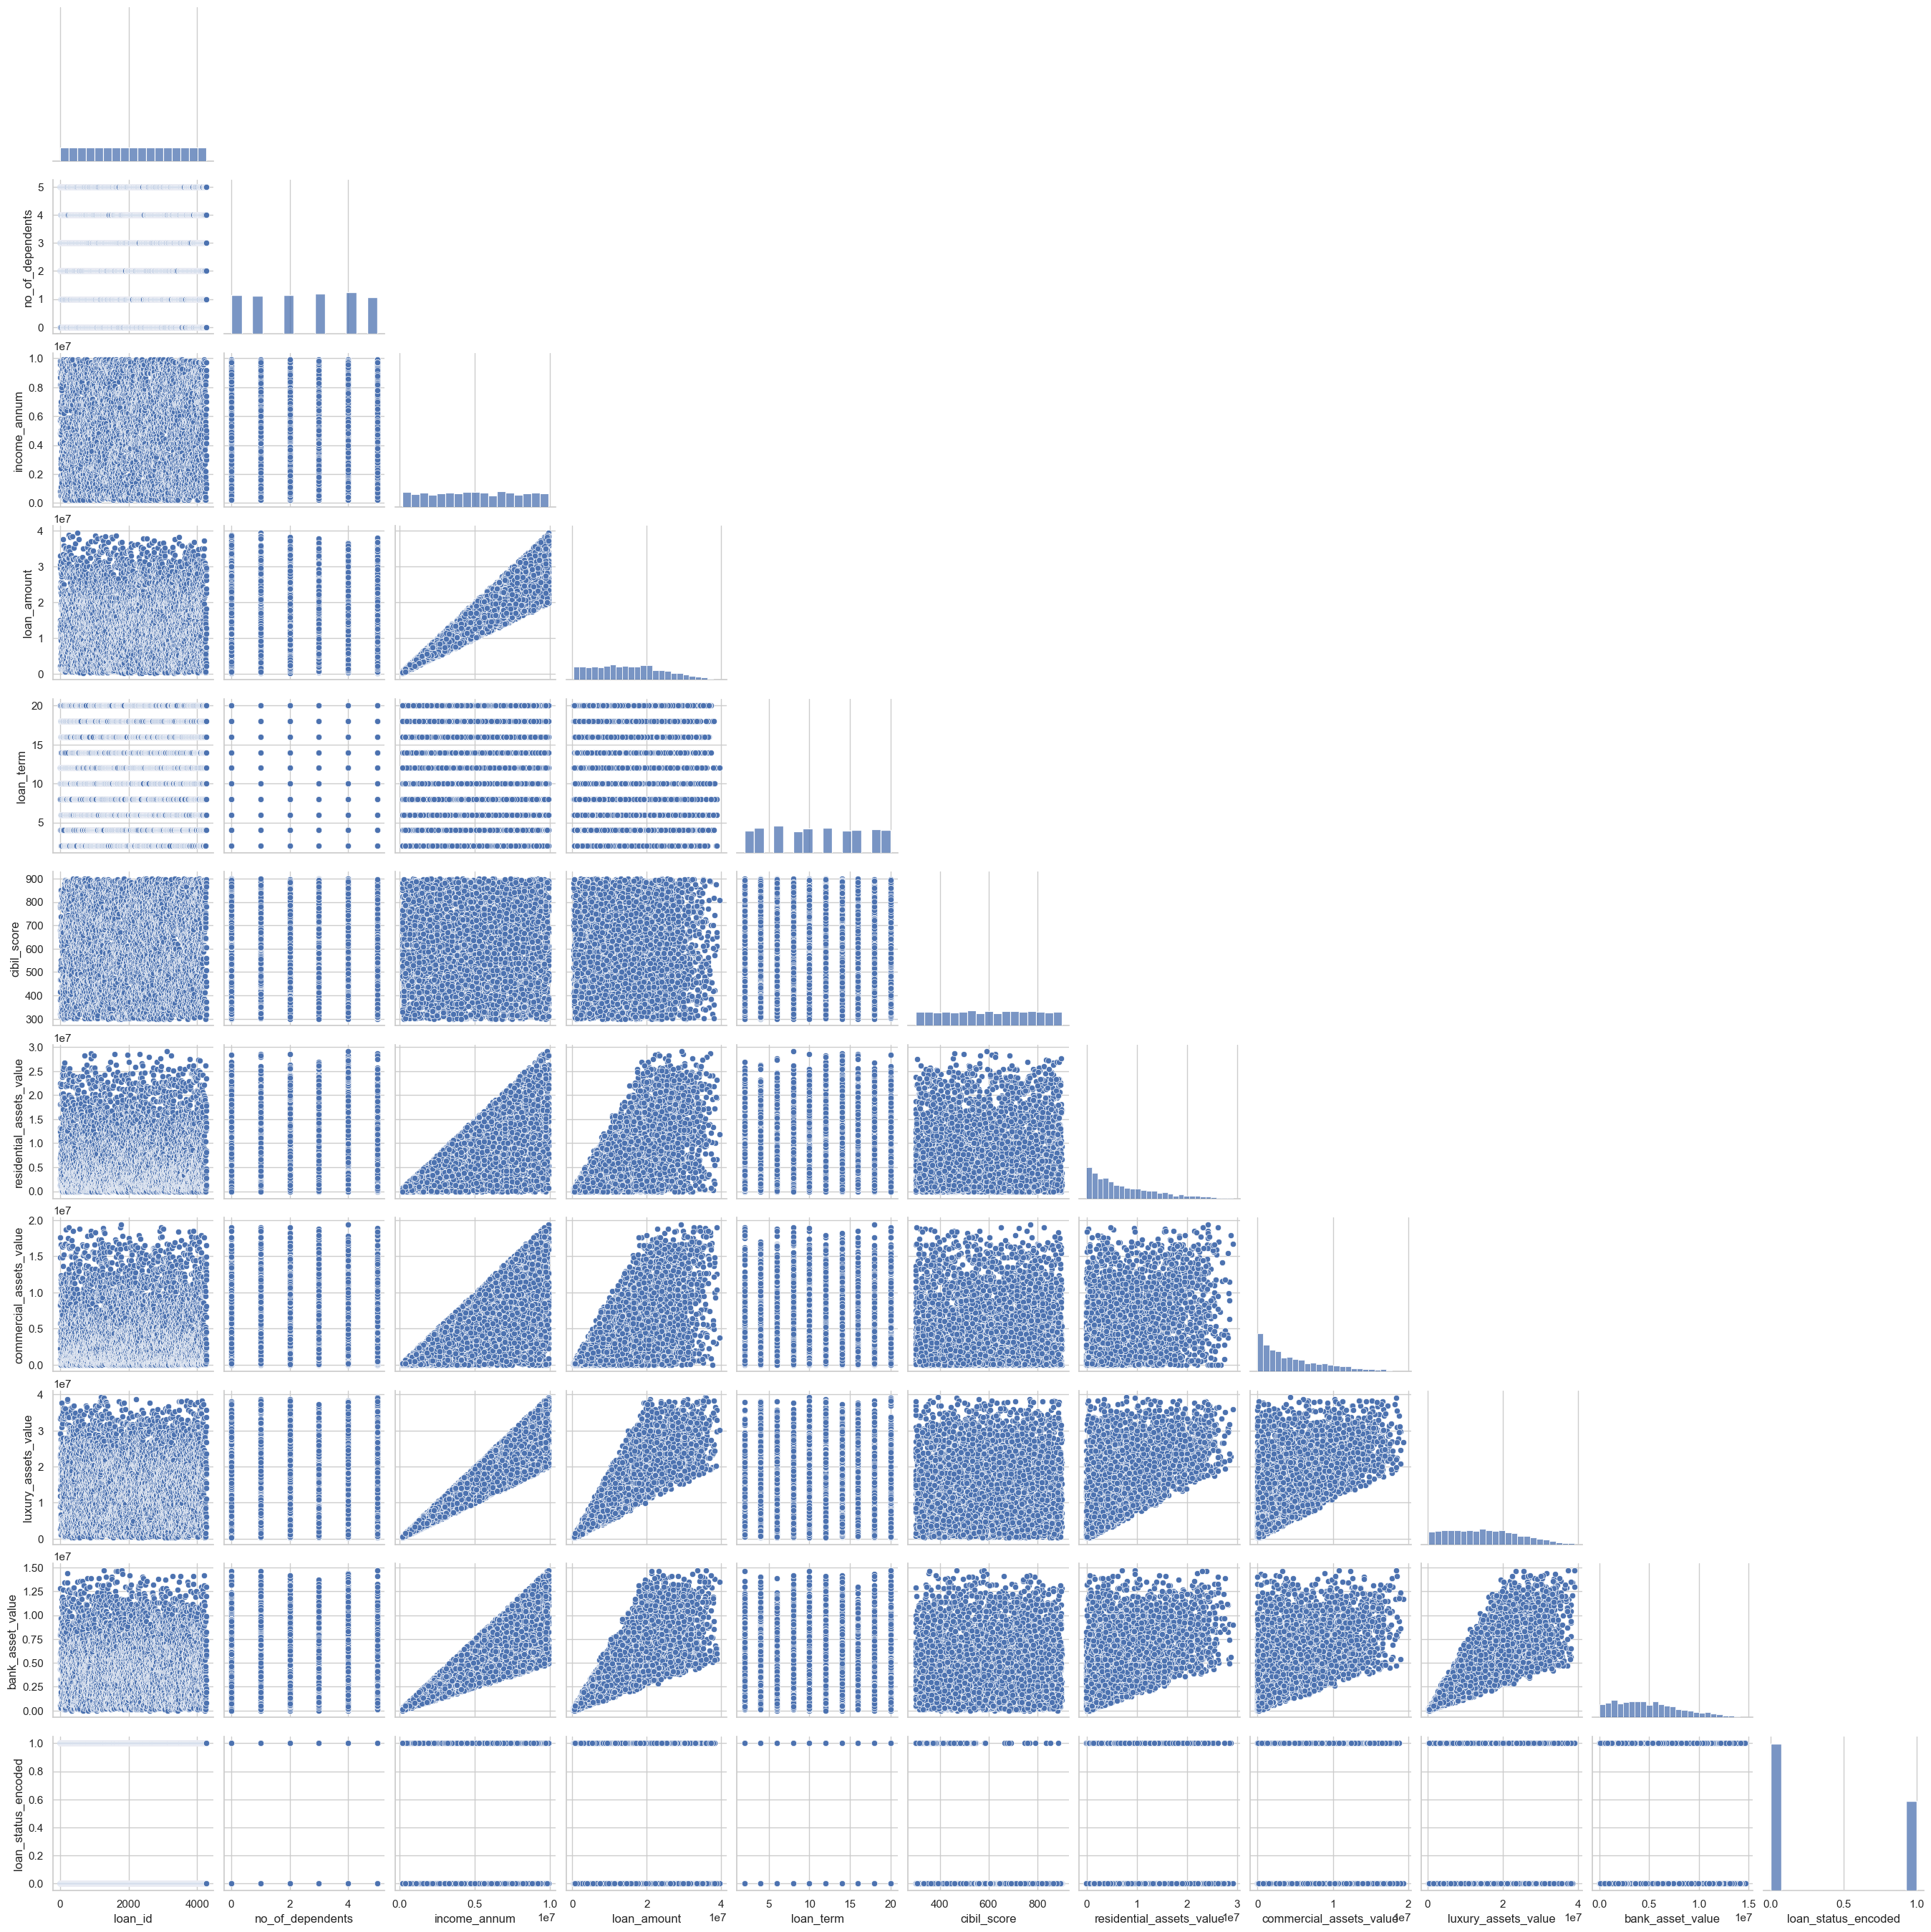

In [9]:
# Pair Plot for a subset of important numerical columns and the target
cols_for_pairplot = numeric_cols.copy()
# Ensuring that the target is considered in the pairplot if encoded
if 'loan_status' in df.columns:
    df['loan_status_encoded'] = pd.factorize(df['loan_status'])[0]
    cols_for_pairplot.append('loan_status_encoded')

sns.pairplot(df[cols_for_pairplot].dropna(), corner=True, diag_kind='hist')
plt.show()

In [10]:
# Rename columns: strip extra spaces from column names
df.columns = df.columns.str.strip()

# Optional: Rename columns to more convenient names
df.rename(columns={
    'no_of_dependents': 'dependents',
    'education': 'education',
    'self_employed': 'self_employed',
    'income_annum': 'income_annual',
    'loan_amount': 'loan_amount',
    'loan_term': 'loan_term',
    'cibil_score': 'cibil_score',
    'residential_assets_value': 'residential_value',
    'commercial_assets_value': 'commercial_value',
    'luxury_assets_value': 'luxury_value',
    'bank_asset_value': 'bank_value',
    'loan_status': 'loan_status'
}, inplace=True)

# Check again for missing values
print('Missing values after renaming:')
print(df.isnull().sum())

# Handle missing values if any (this is a simplistic approach)
df.fillna(method='ffill', inplace=True)

print('Missing values after imputation:')
print(df.isnull().sum())

Missing values after renaming:
loan_id                0
dependents             0
education              0
self_employed          0
income_annual          0
loan_amount            0
loan_term              0
cibil_score            0
residential_value      0
commercial_value       0
luxury_value           0
bank_value             0
loan_status            0
loan_status_encoded    0
dtype: int64
Missing values after imputation:
loan_id                0
dependents             0
education              0
self_employed          0
income_annual          0
loan_amount            0
loan_term              0
cibil_score            0
residential_value      0
commercial_value       0
luxury_value           0
bank_value             0
loan_status            0
loan_status_encoded    0
dtype: int64


In [11]:
# For our predictor, we need to convert categorical columns to numeric.
# Let's check which columns are object type
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print('Categorical columns:', categorical_cols)

# We must exclude the target variable from encoding if we want to handle it separately
categorical_cols = [col for col in categorical_cols if col != 'loan_status']

# One-hot encoding for categorical features
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print('Data shape after one-hot encoding:', df_encoded.shape)

Categorical columns: ['education', 'self_employed', 'loan_status']
Data shape after one-hot encoding: (4269, 14)


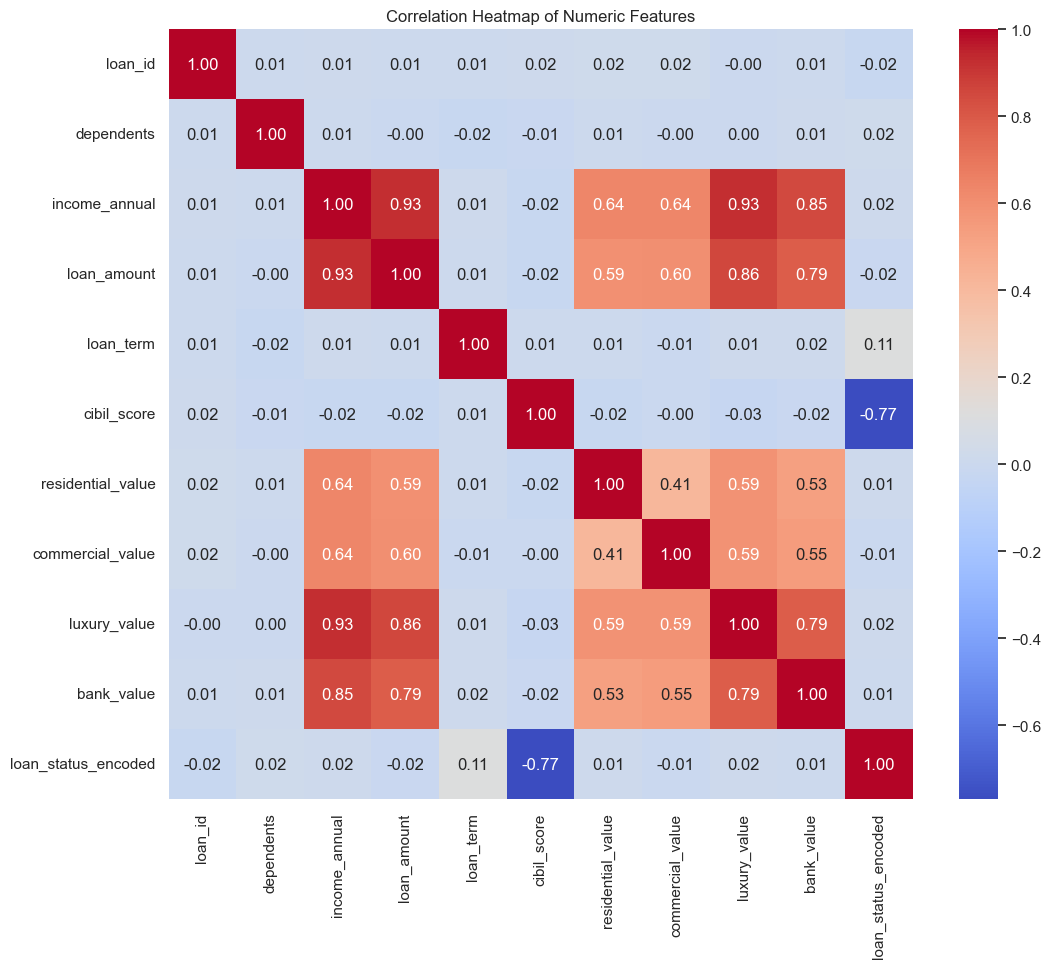

In [12]:
# Use only numeric columns for correlation heatmap
numeric_df = df_encoded.select_dtypes(include=[np.number])

if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(12, 10))
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()
else:
    print('Not enough numeric columns for a meaningful heatmap.')

In [13]:
# Prepare features and target for prediction

# The target variable is 'loan_status'. We will encode it as binary (e.g., Approved=1, Not Approved=0).
df_encoded['loan_status_encoded'] = pd.factorize(df_encoded['loan_status'])[0]

# Drop columns that will not be used for prediction
# For instance, 'loan_id' is nominal and not useful
if 'loan_id' in df_encoded.columns:
    df_encoded.drop(columns=['loan_id'], inplace=True)

# Also drop the original 'loan_status' to keep only encoded target
df_encoded.drop(columns=['loan_status'], inplace=True)

# Define feature set X and target y
X = df_encoded.drop(columns=['loan_status_encoded'])
y = df_encoded['loan_status_encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Training Feature Shape:', X_train.shape)
print('Testing Feature Shape:', X_test.shape)

# Create a logistic regression predictor
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy score
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy Score: {acc:.2f}')

Training Feature Shape: (3415, 11)
Testing Feature Shape: (854, 11)
Accuracy Score: 0.80


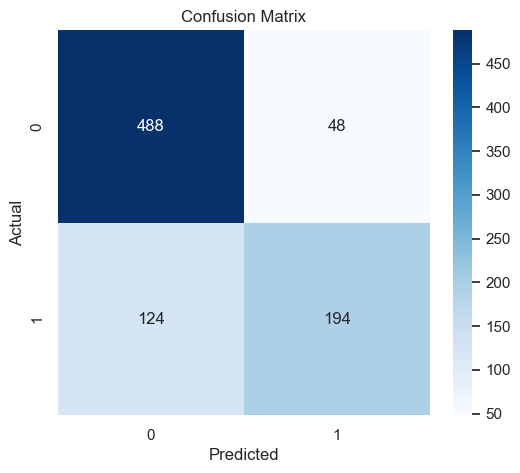

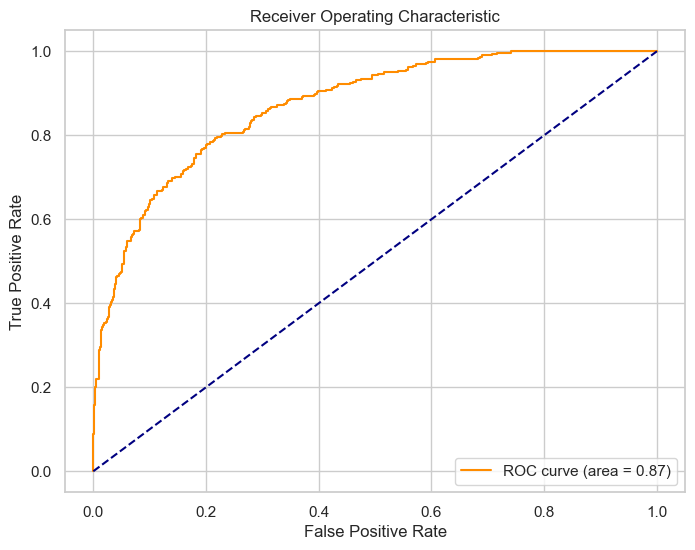

In [14]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve Analysis
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()